In [1]:
from functions import *

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import rasterio
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point
import requests
from scipy.stats import ks_2samp
import shutil
from matplotlib.colors import LogNorm

# Load data

#### Load raw data paths

In [3]:
W = 256
source_path = '../data/raw/'
data_paths = ['lst', 'wt','ndvi']#, 'ndvi', 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {}
for i,dir_p in enumerate(dir_paths):
    all_dir_paths[data_paths[i]] = []
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p:
            all_dir_paths[data_paths[i]].append(subdir)
        #data, times = load_data(dir_paths,W,list_rgb)
all_dir_paths


{'lst': ['../data/raw/lst/cell_1850',
  '../data/raw/lst/cell_1572',
  '../data/raw/lst/cell_570',
  '../data/raw/lst/cell_776',
  '../data/raw/lst/cell_770',
  '../data/raw/lst/cell_1294',
  '../data/raw/lst/cell_1830',
  '../data/raw/lst/cell_310',
  '../data/raw/lst/cell_287',
  '../data/raw/lst/cell_759',
  '../data/raw/lst/cell_163',
  '../data/raw/lst/cell_1135',
  '../data/raw/lst/cell_1081',
  '../data/raw/lst/cell_550',
  '../data/raw/lst/cell_1727',
  '../data/raw/lst/cell_1780',
  '../data/raw/lst/cell_1688',
  '../data/raw/lst/cell_1519',
  '../data/raw/lst/cell_1109',
  '../data/raw/lst/cell_1686',
  '../data/raw/lst/cell_489',
  '../data/raw/lst/cell_914',
  '../data/raw/lst/cell_126',
  '../data/raw/lst/cell_492',
  '../data/raw/lst/cell_201',
  '../data/raw/lst/cell_749',
  '../data/raw/lst/cell_797',
  '../data/raw/lst/cell_120',
  '../data/raw/lst/cell_231',
  '../data/raw/lst/cell_985',
  '../data/raw/lst/cell_1002',
  '../data/raw/lst/cell_1577',
  '../data/raw/lst/

#### Old step to change ndvi images names

In [ ]:
'''pattern = r'^cell_\d+_'
for path in all_dir_paths['ndvi']:
    image_files = os.listdir(path)
    new_files = [re.sub(pattern, '', filename) for filename in image_files]
    new_files = [new_name.replace('_','-',1) for new_name in new_files]
    for i,img in enumerate(image_files):
        old_path = os.path.join(path, img)
        new_path = os.path.join(path, new_files[i])
        print('From ', old_path,'to ', new_path)
        os.rename(old_path, new_path)'''



#### Obtain and  filter common cells between all variables paths

In [4]:
cell_sets = []
for key, paths in all_dir_paths.items():
    cell_ids = set()
    for path in paths:
        if os.listdir(path):
            cell_id = path.split('_')[-1]
            cell_ids.add(cell_id)
            
    #cell_ids = {path.split('_')[-1] for path in paths}  # Extrae solo el número después de "cell_"
    cell_sets.append(cell_ids)

# Obtener la intersección de todos los sets de cell_ids
common_cells = set.intersection(*cell_sets)

# Filtrar cada lista en el diccionario según los cell_ids comunes
filtered_data = {}
for key, paths in all_dir_paths.items():
    filtered_data[key] = [path for path in paths if path.split('_')[-1] in common_cells]

for k,v in filtered_data.items():
    print(k,len(v))
    for el in v:
        print(len(os.listdir(el)))
    print()

lst 24
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82

wt 24
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82

ndvi 24
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82



In [5]:
### Check
for k,v in filtered_data.items():
    print(k,len(v))
    for i,el in enumerate(v):
        p1=filtered_data['wt'][i].split('_')[-1]
        p2=filtered_data['lst'][i].split('_')[-1]
        p3=filtered_data['ndvi'][i].split('_')[-1]
        print(p1,p2,p3)
        
    print()

lst 24
163 163 163
201 201 201
146 146 146
398 398 398
72 72 72
180 180 180
212 212 212
106 106 106
23 23 23
222 222 222
379 379 379
176 176 176
386 386 386
296 296 296
321 321 321
197 197 197
237 237 237
93 93 93
367 367 367
279 279 279
354 354 354
239 239 239
27 27 27
4 4 4

wt 24
163 163 163
201 201 201
146 146 146
398 398 398
72 72 72
180 180 180
212 212 212
106 106 106
23 23 23
222 222 222
379 379 379
176 176 176
386 386 386
296 296 296
321 321 321
197 197 197
237 237 237
93 93 93
367 367 367
279 279 279
354 354 354
239 239 239
27 27 27
4 4 4

ndvi 24
163 163 163
201 201 201
146 146 146
398 398 398
72 72 72
180 180 180
212 212 212
106 106 106
23 23 23
222 222 222
379 379 379
176 176 176
386 386 386
296 296 296
321 321 321
197 197 197
237 237 237
93 93 93
367 367 367
279 279 279
354 354 354
239 239 239
27 27 27
4 4 4



#### Delete data from 2011-01 to 2013-02 (data collection error)

In [6]:
from datetime import datetime
start_date = datetime.strptime("2011-01", "%Y-%m")
end_date = datetime.strptime("2013-02", "%Y-%m")
        
for k, v in filtered_data.items():
    if k != 'ndvi':
        for el in v:
            files = os.listdir(el)
            
            # Iterar sobre los archivos en el directorio
            for filename in files:
                # Extraer la fecha (YYYY-MM) del nombre del archivo
                try:
                    date_str = filename.split('_')[-1].split('.')[0]  # Asumiendo que la fecha está al inicio del nombre
                    file_date = datetime.strptime(date_str, "%Y-%m")
                    
                    # Verificar si la fecha está dentro del rango y eliminar el archivo si corresponde
                    if start_date <= file_date <= end_date:
                        file_path = os.path.join(el, filename)
                        os.remove(file_path)
                        print(f"Eliminado: {file_path}")
                except ValueError:
                    # Ignorar archivos que no tengan el formato de fecha esperado
                    print(f"Formato de fecha no válido en: {filename}")

#### Load images and times

In [7]:
t=[]
total_data = {}
for k,v in filtered_data.items():
    print('doing',k)
    if k == 'lst':
        list_rgb = [True]*len(v)
    else:
        list_rgb = [False]*len(v)
    data, times = load_data(v,W,list_rgb)
    filtered = [arr for arr in data.values() if arr.size > 0]
    total_data[k] = np.concatenate(filtered, axis=0)
    print(total_data[k].shape)
    t.append(times)

doing lst
(1968, 256, 256, 3)
doing wt
(1968, 256, 256)
doing ndvi


/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


(1968, 256, 256)


In [8]:
lst = total_data['lst']
ndvi = total_data['ndvi']
data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (1968, 256, 256, 3) (1968, 256, 256)
targets shape: (1968, 256, 256)


In [9]:
gdf_points = gpd.read_file('../data/external/wt_filtered/wt_filtered.geojson')
times_gdf = gdf_points.time.dt.strftime("%Y-%m").unique()
months = gdf_points.time.dt.month.unique()

In [32]:
time_slots = [el for t in times for el in t]
time_slots = np.array(time_slots)
time_slots

array(['2013-03', '2013-04', '2013-05', ..., '2019-10', '2019-11',
       '2019-12'], dtype='<U7')

In [33]:
len(time_slots)

1968

# Delete unuseful data

In [45]:
del_indices = set()
fixed_ndvi = []
test_index = 0
for index in range(0,lst.shape[0]):
  # Obtain percentage of black and white pixels of lst
  print('imatge', index)
  for k in total_data.keys():
    if k != 'wt':
        print('fent', k)
        if len(total_data[k][index].shape) == 2:
          img_gray = total_data[k][index]
        else:
          img_gray = np.dot(total_data[k][index][...,:3], [0.2989, 0.5870, 0.1140])
        
        blacks = img_gray==0
        percentage_b = np.sum(blacks)/blacks.size * 100
        whites = img_gray>=240
        percentage_w = np.sum(whites)/whites.size * 100
        num_nans = np.sum(np.isnan(img_gray))
        percentage_nans = (num_nans*100)/(img_gray.size)
        print('tinc ',num_nans,' sobre ',img_gray.size,' ocupen un percentatge', percentage_nans)
        conditions = [np.all(img_gray == img_gray[0, 0]), percentage_b > 50, percentage_w > 50,np.all(np.isnan(img_gray)), percentage_nans > 50]
        
        if True in conditions:
            del_indices.add(index)
        elif k == 'ndvi':
            new_ndvi = np.where(np.isnan(total_data[k][index]), 0.0, total_data[k][index])
            fixed_ndvi.append(new_ndvi)
  print()
  

imatge 0
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  14431  sobre  65536  ocupen un percentatge 22.01995849609375
eee 0

imatge 1
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  41604  sobre  65536  ocupen un percentatge 63.482666015625

imatge 2
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  65536  sobre  65536  ocupen un percentatge 100.0

imatge 3
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  31182  sobre  65536  ocupen un percentatge 47.5799560546875
eee 0

imatge 4
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  15817  sobre  65536  ocupen un percentatge 24.13482666015625
eee 0

imatge 5
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  65536  sobre  65536  ocupen un percentatge 100.0

imatge 6
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  1780  sobre  65536  ocupen un percentatge 2.716064453125

In [13]:
fixed_ndvi = np.array(fixed_ndvi)

In [14]:
slots = np.delete(time_slots,list(del_indices))

In [15]:
len(slots)

265

# Mask Landsat data

In [85]:
dir_path = '../data/external/raster_masks/'
files = os.listdir(dir_path)
river_masks = {}
river_masks_expanded = {}
for raster in files:
    cl_int=raster.split('bw_cell_')[-1].split('.')[0]
    cc = raster.split('bw_')[-1].split('.')[0]
    if cl_int in common_cells:
        raster_path = os.path.join(dir_path, raster)
        rast,meta = load_raster(raster_path,False)
        river_masks[cc]=rast
        river_mask_expanded = np.expand_dims(river_mask, axis=-1)  # Expande para tener forma (height, width, 1)
        river_mask_expanded = np.repeat(river_mask_expanded, lst.shape[-1], axis=-1)  # Expande a (height, width, 3)
        river_masks_expanded[cc] = river_mask_expanded
    
        
    #plt.imshow(rast)
    #plt.show()

In [86]:
river_masks_expanded.keys()

dict_keys(['cell_146', 'cell_93', 'cell_379', 'cell_197', 'cell_222', 'cell_106', 'cell_321', 'cell_176', 'cell_296', 'cell_398', 'cell_354', 'cell_212', 'cell_237', 'cell_279', 'cell_4', 'cell_201', 'cell_386', 'cell_180', 'cell_239', 'cell_27', 'cell_23', 'cell_72', 'cell_163', 'cell_367'])

In [79]:
count = 0
masked_inputs = []
for i,river_mask in enumerate(river_masks):
    #print('Selected image shape:', river_mask.shape)
    cc=files[i].split('bw_')[-1].split('.')[0]
    print(cc)
    if cc in rivers.keys():
        for i in range(len(t[0][0])):
            river_mask_expanded = np.expand_dims(river_mask, axis=-1)  # Expande para tener forma (height, width, 1)
            river_mask_expanded = np.repeat(river_mask_expanded, lst.shape[-1], axis=-1)  # Expande a (height, width, 3)
    
            ind = i + count
            if ind not in del_indices:
                input_img = lst[ind]
                masked_input = input_img * river_mask_expanded  # Aplica la máscara a los inputs
                masked_inputs.append(masked_input)
                #plt.imshow(masked_input)
                #plt.show()
           
    count += len(t[0][0])

# Convierte  de nuevo a arrays de numpy
masked_inputs = np.array(masked_inputs)

# Verifica las formas
print('masked inputs shape:', masked_inputs.shape)
    

cell_1522
cell_733
cell_349
cell_956
cell_1186
cell_1787
cell_210
cell_146
cell_842
cell_1089
cell_1420
cell_1320
cell_556
cell_824
cell_1499
cell_939
cell_593
cell_703
cell_32
cell_1601
cell_1256
cell_995
cell_978
cell_1768
masked inputs shape: (196, 256, 256, 3)


# Mask NDVI data

In [ ]:
count = 0
masked_inputs_ndvi = []
for river_mask in river_masks:
    for i in range(len(t[0])):
        ind = i + count
        if ind not in del_indices:
            input_img = ndvi[ind]
            masked_input = input_img * river_mask # Aplica la máscara a los inputs
            masked_inputs_ndvi.append(masked_input)
            plt.imshow(masked_input)
            plt.show()
       
    count += len(t[0])

# Convierte  de nuevo a arrays de numpy
masked_inputs_ndvi = np.array(masked_inputs_ndvi)

# Verifica las formas
print('masked inputs shape:', masked_inputs_ndvi.shape)
    

# Download preprocessed data

#### Load rivers

In [21]:
import os
import fiona
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union

all_rivers = {}
output_directory = '../data/external/shp/clipped_rivers_grid_cells_ogr'
a=0

for i,riv in enumerate(os.listdir(output_directory)):
    # Check if the file is a shapefile
    try:
        if riv.endswith('.shp'):
            a+=1
            print(f"Processing file: {riv}")
            river = gpd.read_file(os.path.join(output_directory, riv))
            river = river.to_crs("EPSG:4326")
            all_rivers[f'cell_{i}'] = river
            print('Added', f'cell_{i}')

    except Exception as e:
        print(f"Error processing file: {riv}",e)
        pass
        

Processing file: rivers_grid_cell_666.shp
Added cell_4
Processing file: rivers_grid_cell_320.shp
Added cell_10
Processing file: rivers_grid_cell_187.shp
Added cell_19
Processing file: rivers_grid_cell_754.shp
Added cell_20
Processing file: rivers_grid_cell_567.shp
Added cell_21
Processing file: rivers_grid_cell_490.shp
Added cell_23
Processing file: rivers_grid_cell_328.shp
Added cell_24
Processing file: rivers_grid_cell_597.shp
Added cell_27
Processing file: rivers_grid_cell_242.shp
Added cell_28
Processing file: rivers_grid_cell_304.shp
Added cell_32
Processing file: rivers_grid_cell_109.shp
Added cell_52
Processing file: rivers_grid_cell_285.shp
Added cell_61
Processing file: rivers_grid_cell_405.shp
Added cell_63
Processing file: rivers_grid_cell_199.shp
Added cell_66
Processing file: rivers_grid_cell_356.shp
Added cell_67
Processing file: rivers_grid_cell_418.shp
Added cell_72
Processing file: rivers_grid_cell_303.shp
Added cell_80
Processing file: rivers_grid_cell_478.shp
Added c

In [18]:
import os
import fiona
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union

rivers = {}
included_files = []
output_directory = '../data/external/shp/clipped_rivers_grid_cells_ogr'
a=0

for i,riv in enumerate(os.listdir(output_directory)):
    # Check if the file is a shapefile
    try:
        if riv.endswith('.shp'):
            a+=1
            print(f"Processing file: {riv}")
            river = gpd.read_file(os.path.join(output_directory, riv))
            combined_river = unary_union(river.geometry)
            
            total_length = combined_river.length  # Longitud total en metros

            # Calcular el área del bounding box de la geometría combinada
            bounding_box = river.total_bounds  # [minx, miny, maxx, maxy]
            width = bounding_box[2] - bounding_box[0]
            height = bounding_box[3] - bounding_box[1]
            area = width * height  # Área en metros 

            bounding_box_diagonal = ((bounding_box[2] - bounding_box[0])**2 + (bounding_box[3] - bounding_box[1])**2)**0.5

            length_percentage = (total_length / bounding_box_diagonal) * 100  # Comparación en función de la diagonal
            
            # Definir umbrales
            min_area_threshold = 100000000  # Área mínima en m² (0.225 km²)100_000_000
            min_length_threshold = 3000  # Longitud mínima en metros

            # Plot the GeoDataFrame
            river = river.to_crs("EPSG:4326")
           
            if area >= min_area_threshold and total_length > min_length_threshold and length_percentage > 50:                
                river = river.to_crs("EPSG:4326")
                rivers[f'cell_{i}'] = river
                included_files.append(riv)
                print('Added', f'cell_{i}')

    except Exception as e:
        print(f"Error processing file: {riv}",e)
        pass
        

Processing file: rivers_grid_cell_666.shp
Processing file: rivers_grid_cell_320.shp
Added cell_10
Processing file: rivers_grid_cell_187.shp
Processing file: rivers_grid_cell_754.shp
Processing file: rivers_grid_cell_567.shp
Added cell_21
Processing file: rivers_grid_cell_490.shp
Added cell_23
Processing file: rivers_grid_cell_328.shp
Added cell_24
Processing file: rivers_grid_cell_597.shp
Added cell_27
Processing file: rivers_grid_cell_242.shp
Processing file: rivers_grid_cell_304.shp
Added cell_32
Processing file: rivers_grid_cell_109.shp
Added cell_52
Processing file: rivers_grid_cell_285.shp
Processing file: rivers_grid_cell_405.shp
Processing file: rivers_grid_cell_199.shp
Added cell_66
Processing file: rivers_grid_cell_356.shp
Added cell_67
Processing file: rivers_grid_cell_418.shp
Added cell_72
Processing file: rivers_grid_cell_303.shp
Added cell_80
Processing file: rivers_grid_cell_478.shp
Added cell_85
Processing file: rivers_grid_cell_212.shp
Processing file: rivers_grid_cell_

#### Clean rivers

In [ ]:
valid_directory = '../data/external/shp/cleaned_cells'
os.makedirs(valid_directory, exist_ok=True)
for riv in included_files:
    base_name = os.path.splitext(riv)[0]
    for ext in [".shp", ".shx", ".dbf", ".prj"]:
        source_path = os.path.join(output_directory, base_name + ext)
        destination_path = os.path.join(valid_directory, base_name + ext)
        try:
            shutil.copy(source_path, destination_path)
            print(f"Moved file: {source_path} to {destination_path}")
        except FileNotFoundError:
            pass

#### Clean preprocessed directories

In [91]:
raw_data_path = '../data/raw/'
preprocessed_data_path = '../data/preprocessed/'

data = ['lst', 'ndvi', 'wt']#,'wt_interpolated', 'lst/masked']
for d in data:
    dest_dir = os.path.join(preprocessed_data_path, d)
    os.makedirs(dest_dir, exist_ok=True)
    clear_directory(dest_dir)
    
'''for r in rivers.keys():
    dest_dir = os.path.join(preprocessed_data_path, d+f'/{r}')#f'{d}/{r}')
    os.makedirs(dest_dir, exist_ok=True)
    clear_directory(dest_dir)
    if d == 'lst':
      dest_dir_m = os.path.join(dest_dir, 'masked')
      os.makedirs(dest_dir_m, exist_ok=True)
      clear_directory(dest_dir_m)'''

"for r in rivers.keys():\n    dest_dir = os.path.join(preprocessed_data_path, d+f'/{r}')#f'{d}/{r}')\n    os.makedirs(dest_dir, exist_ok=True)\n    clear_directory(dest_dir)\n    if d == 'lst':\n      dest_dir_m = os.path.join(dest_dir, 'masked')\n      os.makedirs(dest_dir_m, exist_ok=True)\n      clear_directory(dest_dir_m)"

#### Copy preprocessed images

In [92]:
from collections import Counter

for d, paths in filtered_data.items():
    count = 0
    included = 0
    imgs_per_river = Counter()
    imgs_out=0
    
    for cell_path in paths:
        source_dir = cell_path
        cell = cell_path.split('/')[-1]
        dest_dir = os.path.join(preprocessed_data_path, f'{d}/{cell}')
        os.makedirs(dest_dir, exist_ok=True)
        
        try:
            river = rivers[cell]
            files = os.listdir(source_dir)
            sorted_files = sorted(files, key=extract_year_month_from_filename)
    
            for file in sorted_files:
                if count not in del_indices:
                    # Construct full file paths
                    if d == 'ndvi':
                        date = file.split('_')[0]#.split('.')[0]
                        print(date, time_slots[included])
                        name = f'{dest_dir}/ndvi_{date}.tiff'
                        save_raster(fixed_ndvi[included], name, river)
                        print('Image', included)
                        print(f'Copied: ndvi_{date}, at {dest_dir}')

                        masked_dir = f'{dest_dir}/masked'
                        os.makedirs(masked_dir, exist_ok=True)
                        name = f'{masked_dir}/lst_masked_{date}.tiff'
                        masked_input = fixed_ndvi[included] * river_masks[cell]
                        save_raster(masked_input, name, river)
                        print(f'Copied: ndvi_masked_{date}')
                    else:
                        #dst_path = os.path.join(dest_dir, image_file)
                        dst_path = os.path.join(dest_dir, file)
                        src_path = os.path.join(source_dir, file)
                        # Copy the file to the destination folder
                        shutil.copy(src_path, dst_path)
                        print()
                        print('Image', included)
                        print(f'Copied: {file}, from {src_path}, to {dst_path}')
    
                        if d == 'lst':
                            date = file.split('_')[1].split('.')[0]
                            masked_dir = f'{dest_dir}/masked'
                            os.makedirs(masked_dir, exist_ok=True)
                            name = f'{masked_dir}/lst_masked_{date}.tiff'
                            masked_input = lst[count] * river_masks_expanded[cell]
                            save_raster(masked_input, name, river)
                            print(f'Copied: lst_masked_{date}')
                    included+=1
                    imgs_per_river[cell] += 1
                count+=1
        except:
            imgs_out += len(os.listdir(source_dir))
            rr = all_rivers[cell]
            print(cell)
            #rr.plot()
            #plt.show()
            print()
            print('afegeixo',len(os.listdir(source_dir)), 'imatges no processades')
            count += len(os.listdir(source_dir))
            pass
        
                


Image 0
Copied: image_2013-09.tiff, from ../data/raw/lst/cell_163/image_2013-09.tiff, to ../data/preprocessed/lst/cell_163/image_2013-09.tiff
Copied: lst_masked_2013-09

Image 1
Copied: image_2014-09.tiff, from ../data/raw/lst/cell_163/image_2014-09.tiff, to ../data/preprocessed/lst/cell_163/image_2014-09.tiff
Copied: lst_masked_2014-09

Image 2
Copied: image_2015-01.tiff, from ../data/raw/lst/cell_163/image_2015-01.tiff, to ../data/preprocessed/lst/cell_163/image_2015-01.tiff
Copied: lst_masked_2015-01

Image 3
Copied: image_2015-08.tiff, from ../data/raw/lst/cell_163/image_2015-08.tiff, to ../data/preprocessed/lst/cell_163/image_2015-08.tiff
Copied: lst_masked_2015-08

Image 4
Copied: image_2015-11.tiff, from ../data/raw/lst/cell_163/image_2015-11.tiff, to ../data/preprocessed/lst/cell_163/image_2015-11.tiff
Copied: lst_masked_2015-11

Image 5
Copied: image_2016-10.tiff, from ../data/raw/lst/cell_163/image_2016-10.tiff, to ../data/preprocessed/lst/cell_163/image_2016-10.tiff
Copied:

In [37]:
print(np.sum(list(imgs_per_river.values())))
print(imgs_per_river)
print(imgs_out)
print(len(slots))
print(len(imgs_per_river))
print(included)

147
Counter({'cell_27': 24, 'cell_176': 20, 'cell_279': 17, 'cell_354': 17, 'cell_23': 15, 'cell_296': 12, 'cell_93': 9, 'cell_163': 8, 'cell_212': 7, 'cell_197': 7, 'cell_146': 5, 'cell_72': 3, 'cell_180': 3})
902
265
13
147


CHECK

In [48]:
dir_paths = ['../data/preprocessed/ndvi/cell_27/']
W = 256
list_rgb = [False]
data, time_slots_n = load_data(dir_paths,W,list_rgb)

(24, 256, 256)
0


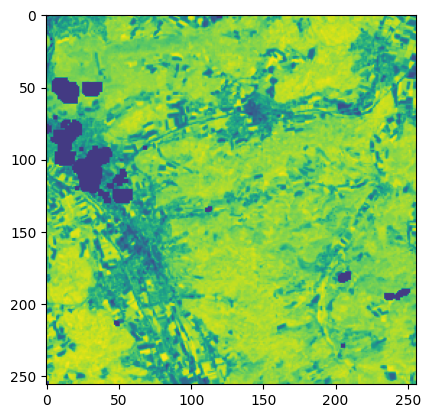

0


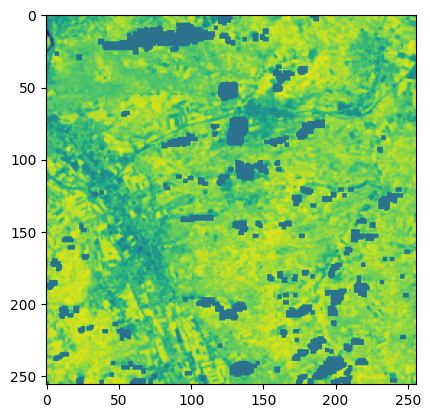

0


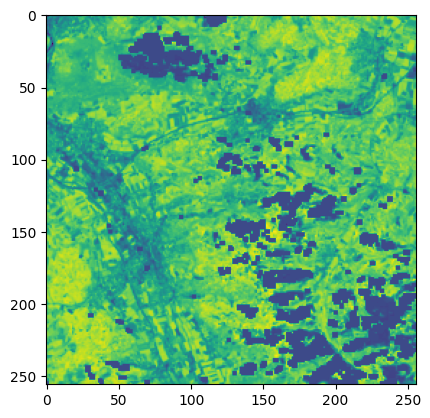

0


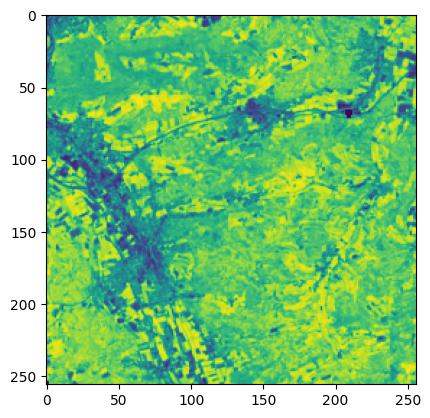

0


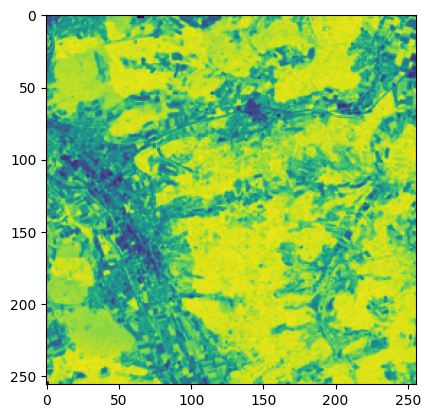

0


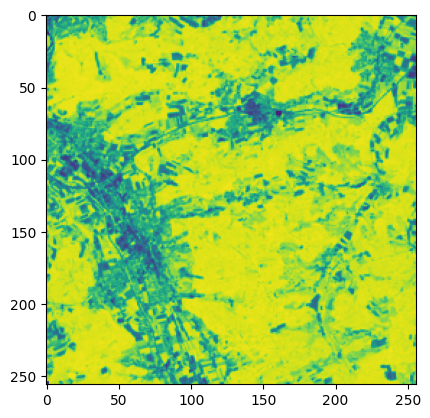

0


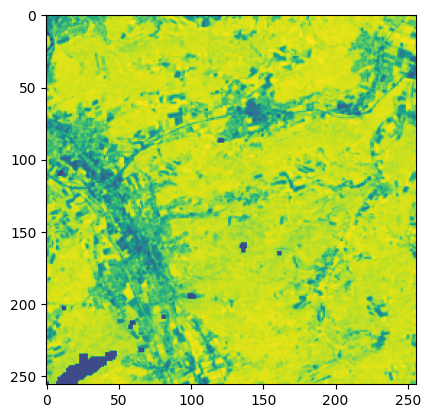

0


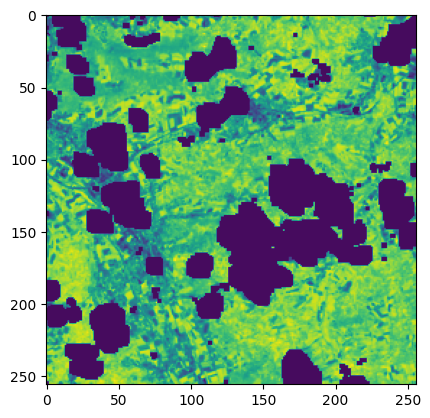

0


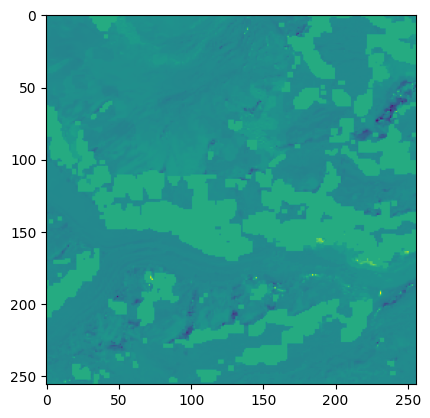

0


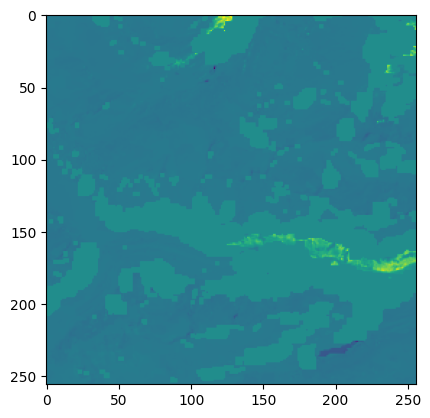

0


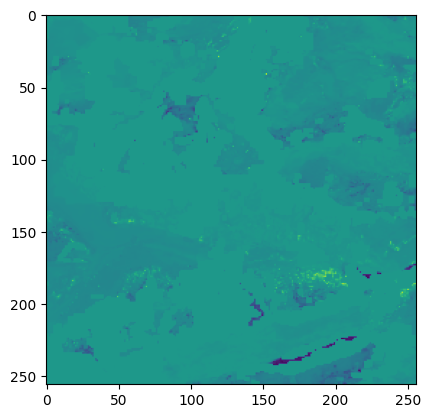

0


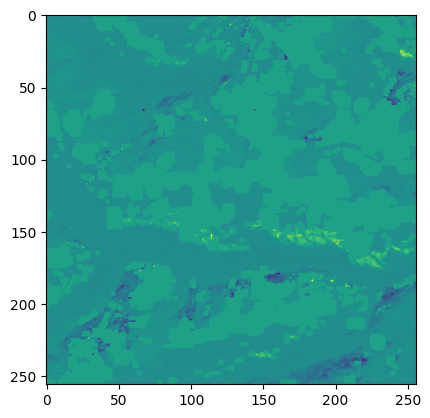

0


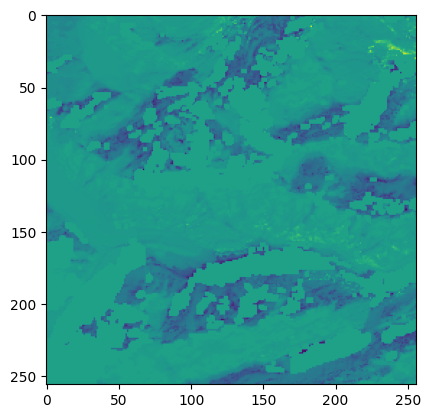

0


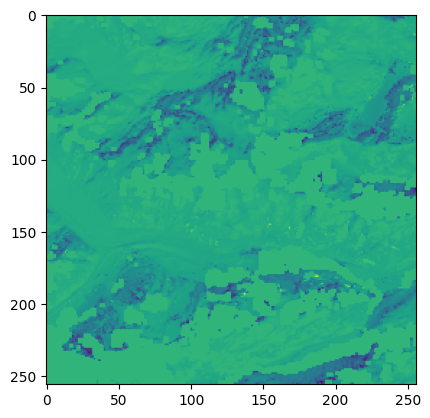

0


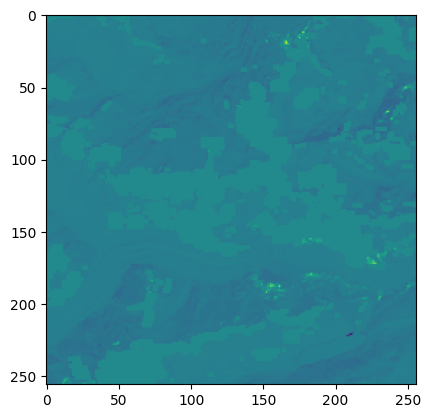

0


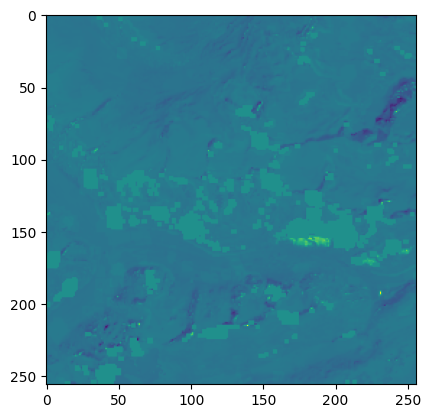

0


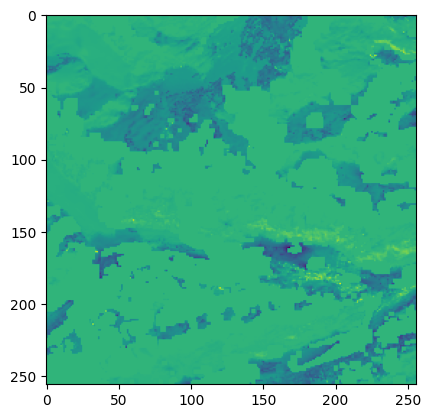

0


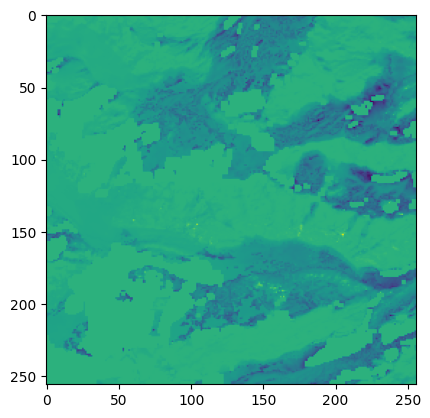

0


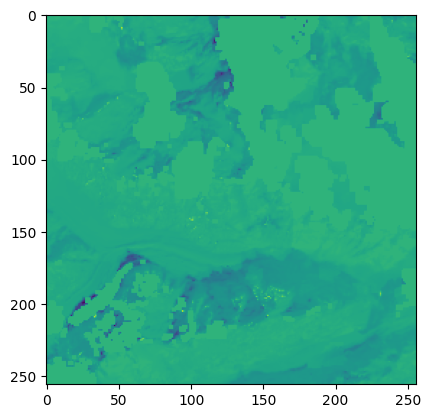

0


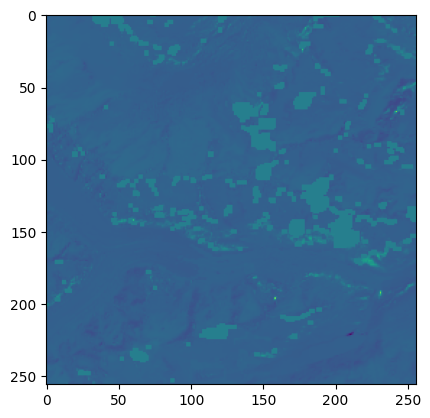

0


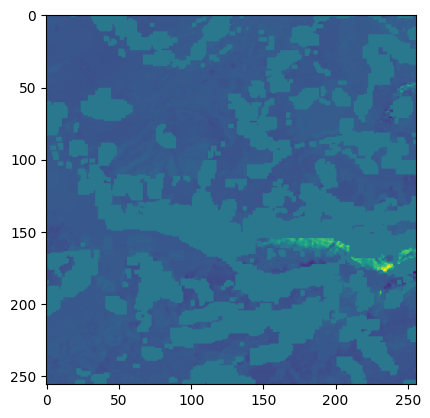

0


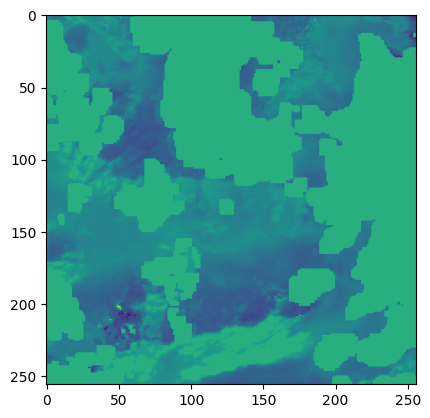

0


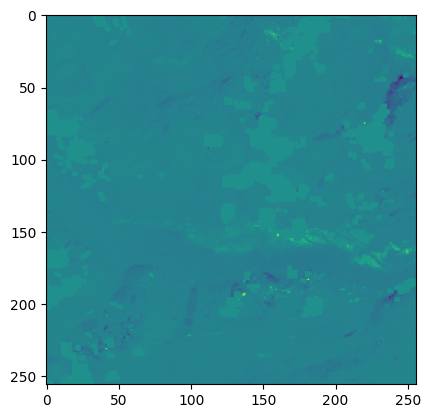

0


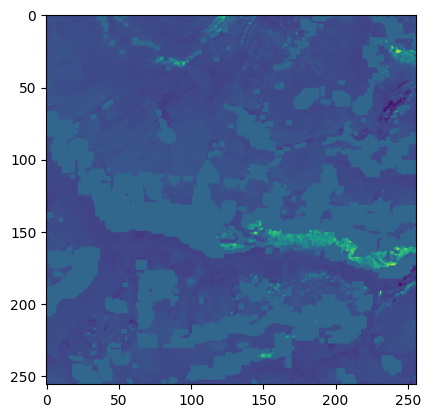

In [49]:
n = data[dir_paths[0]]
print(n.shape)
for i in n:
  print(np.sum(np.isnan(i)))
  plt.imshow(i)
  plt.show()

# Pixel wise dataset creation

In [ ]:
river_indices = np.nonzero(river_mask.reshape(-1))[0]

In [ ]:
len(river_indices)

In [ ]:

import os
source_path = '../data/preprocessed/'
data_paths = ['lst', 'ndvi', 'wt','masked']#,'discharge', 'slope']#, 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k:[] for k in data_paths}

for i,dir_p in enumerate(dir_paths):
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints'): #and rivers_count < max_rivers:
            all_dir_paths[data_paths[i]].append(subdir)
        elif subdir.endswith('masked'):
            all_dir_paths['masked'].append(subdir)

total_data = {}
total_times = {}
filter_river = None
W=256

for k,v in all_dir_paths.items():
    if filter_river != None:
        v = [v[i] for i in filter_river]

    if k != 'discharge' and k != 'slope':
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)

            labels = []
            imgs_per_river = {}
            for ki,value in data.items():
                imgs_per_river[ki.split('/')[-1]] = len(value)
                
                labels+=[ki.split('/')[-1]]*len(value)
                
        

        
        data, times = load_data(v,W,list_rgb)
        
        filtered = [arr for arr in data.values() if arr.size > 0]

        total_data[k] = np.concatenate(filtered, axis=0)
        total_times[k] = times
        print(k,':' ,total_data[k].shape)

    elif k == 'discharge' or k == 'slope':
        total = []
        for p in v:
            for file in os.listdir(p):
                file_path = os.path.join(p, file)
                r,m = load_raster(file_path, False)
                var = resize_image(r, W,W)
                img_river = labels.count(p.split("/")[-1])
                var_input = np.tile(var, (img_river, 1, 1))
                total.append(var_input)
        
        total_data[k] = np.concatenate(total, axis=0)
        print(k,':' ,total_data[k].shape)
lst = total_data['lst']
ndvi = total_data['ndvi']
data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

### LST dataset

In [ ]:
print(len(rivers),len(river_masks))

In [ ]:
all_lst_ds = {}
last = 0
for i, (k,river) in enumerate(rivers.items()):
    river_mask = river_masks[i]
    river_indices = np.nonzero(river_mask.reshape(-1))[0]
    #print(river_indices.shape)
    pixel_ds_lst = pd.DataFrame(columns=[river_indices])
    
    for count in range(imgs_per_river[k]):
        ind = count + last
        image = masked_inputs[ind]
        img_gray = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
        flat_image = img_gray.flatten()
        river_image = flat_image[river_indices]
        pixel_ds_lst.loc[slots[ind]] = river_image
        
    last += imgs_per_river[k]    
    all_lst_ds[k] = pixel_ds_lst
    pixel_ds_lst.to_csv(f'../data/preprocessed/lst/{k}/{k}_lst.csv')
    

### NDVI dataset

In [ ]:
all_ndvi_ds = {}
last = 0
for i, (k,river) in enumerate(rivers.items()):
    river_mask = river_masks[i]
    river_indices = np.nonzero(river_mask.reshape(-1))[0]
    #print(river_indices.shape)
    pixel_ds_ndvi = pd.DataFrame(columns=[river_indices])
    
    for count in range(imgs_per_river[k]):
        ind = count + last
        image = masked_inputs_ndvi[ind]
        flat_image = image.flatten()
        river_image = flat_image[river_indices]
        pixel_ds_ndvi.loc[slots[ind]] = river_image
        
    last += imgs_per_river[k]    
    all_ndvi_ds[k] = pixel_ds_ndvi
    pixel_ds_ndvi.to_csv(f'../data/preprocessed/ndvi/{k}/{k}_ndvi.csv')
    

### Water temperature dataset

In [ ]:
all_wt_ds = {}
last = 0
for i, (k,river) in enumerate(rivers.items()):
    river_mask = river_masks[i]
    river_indices = np.nonzero(river_mask.reshape(-1))[0]
    #print(river_indices.shape)
    pixel_ds_wt = pd.DataFrame(columns=[river_indices])
    
    for count in range(imgs_per_river[k]):
        ind = count + last
        image = data_targets[ind]
        #img_gray = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
        flat_image = image.flatten()
        river_image = flat_image[river_indices]
        pixel_ds_wt.loc[slots[ind]] = river_image
        
    last += imgs_per_river[k]    
    all_wt_ds[k] = pixel_ds_wt
    pixel_ds_wt.to_csv(f'../data/preprocessed/wt/{k}/{k}_wt.csv')
    

### Water temperature stations dataset

In [ ]:
pixel_ds_wt = pd.DataFrame(columns=[river_indices])
pixel_ds_wt

In [ ]:
c = 0
for i in range(len(wt_stations)):
  if times[3][i] in slots:
    image = wt_stations[i]
    flat_image = image.flatten()
    river_image = flat_image[river_indices]
    pixel_ds_wt.loc[slots[c]] = river_image
    c += 1

In [ ]:
pixel_ds_wt

In [ ]:
pixel_ds_wt.to_csv('../data/preprocessed/wt_interpolated/leboiron_wt_interpolated.csv')